# 단어 수준 텍스트 생성

이 노트북은 아래 문서에 실려 있는 예제를 실습하면서 작성한 것입니다.

* [How to Develop a Word-Level Neural Language Model and Use it to Generate Text](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/) - Machine Learning Mastery

## 데이터 준비

* [Download The Republic by Plato (republic.txt)](http://www.gutenberg.org/cache/epub/1497/pg1497.txt)

### 텍스트 읽기

원본 텍스트 파일의 앞 부분과 뒷 부분을 제거한 텍스트를 저장하고 있는 `republic_clean.txt` 파일을 읽습니다.

In [1]:
def load_doc(filename):
    with open(filename, mode='r', encoding='utf-8') as f:
        text = f.read()
        
    return text

in_filename = 'republic_clean.txt'
doc = load_doc(in_filename)
print(doc[:200])

﻿BOOK I.


I went down yesterday to the Piraeus with Glaucon the son of Ariston,
that I might offer up my prayers to the goddess (Bendis, the Thracian
Artemis.); and also because I wanted to see in wh


### 텍스트 정제

In [2]:
import string

def clean_doc(doc):
    doc = doc.replace('--', ' ')
    tokens = doc.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    return tokens

tokens = clean_doc(doc)
print(tokens[:100])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['i', 'i', 'went', 'down', 'yesterday', 'to', 'the', 'piraeus', 'with', 'glaucon', 'the', 'son', 'of', 'ariston', 'that', 'i', 'might', 'offer', 'up', 'my', 'prayers', 'to', 'the', 'goddess', 'bendis', 'the', 'thracian', 'artemis', 'and', 'also', 'because', 'i', 'wanted', 'to', 'see', 'in', 'what', 'manner', 'they', 'would', 'celebrate', 'the', 'festival', 'which', 'was', 'a', 'new', 'thing', 'i', 'was', 'delighted', 'with', 'the', 'procession', 'of', 'the', 'inhabitants', 'but', 'that', 'of', 'the', 'thracians', 'was', 'equally', 'if', 'not', 'more', 'beautiful', 'when', 'we', 'had', 'finished', 'our', 'prayers', 'and', 'viewed', 'the', 'spectacle', 'we', 'turned', 'in', 'the', 'direction', 'of', 'the', 'city', 'and', 'at', 'that', 'instant', 'polemarchus', 'the', 'son', 'of', 'cephalus', 'chanced', 'to', 'catch', 'sight', 'of']
Total Tokens: 117341
Unique Tokens: 7323


### 훈련 데이터 형식으로 변환

일정 개수의 단어를 입력하면 다음 단어를 예측하는 모델에 사용하기 위하여 데이터를 변환합니다.

In [3]:
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
print('0> ' + sequences[0])
print('1> ' + sequences[1])
print('2> ' + sequences[2])

Total Sequences: 117290
0> i i went down yesterday to the piraeus with glaucon the son of ariston that i might offer up my prayers to the goddess bendis the thracian artemis and also because i wanted to see in what manner they would celebrate the festival which was a new thing i was delighted
1> i went down yesterday to the piraeus with glaucon the son of ariston that i might offer up my prayers to the goddess bendis the thracian artemis and also because i wanted to see in what manner they would celebrate the festival which was a new thing i was delighted with
2> went down yesterday to the piraeus with glaucon the son of ariston that i might offer up my prayers to the goddess bendis the thracian artemis and also because i wanted to see in what manner they would celebrate the festival which was a new thing i was delighted with the


### 훈련 데이터 저장

변환한 데이터를 `republic_sequences.txt` 파일로 저장합니다.

In [4]:
def save_doc(lines, filename):
    data = '\n'.join(lines)
    with open(filename, mode='w', encoding='utf-8') as f:
        f.write(data)
        
out_filename = 'republic_sequences.txt'
save_doc(sequences, out_filename)

## 언어 모델 훈련

### 훈련 데이터 읽기

In [5]:
def load_doc(filename):
    with open(filename, mode='r', encoding='utf-8') as f:
        text = f.read()
        
    return text

in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
print('Total Lines: %d' % len(lines))
print('0> ' + lines[0])
print('1> ' + lines[1])
print('2> ' + lines[2])

Total Lines: 117290
0> i i went down yesterday to the piraeus with glaucon the son of ariston that i might offer up my prayers to the goddess bendis the thracian artemis and also because i wanted to see in what manner they would celebrate the festival which was a new thing i was delighted
1> i went down yesterday to the piraeus with glaucon the son of ariston that i might offer up my prayers to the goddess bendis the thracian artemis and also because i wanted to see in what manner they would celebrate the festival which was a new thing i was delighted with
2> went down yesterday to the piraeus with glaucon the son of ariston that i might offer up my prayers to the goddess bendis the thracian artemis and also because i wanted to see in what manner they would celebrate the festival which was a new thing i was delighted with the


### 훈련 데이터 인코딩

In [6]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
print(sequences[1])

2024-03-15 14:47:54.812495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 14:47:55.159093: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 14:47:55.241809: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-15 14:47:55.241841: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

[11, 1032, 326, 7323, 4, 1, 2842, 34, 211, 1, 261, 3, 2841, 9, 11, 179, 808, 123, 92, 2840, 4, 1, 2225, 7322, 1, 7321, 7320, 2, 74, 122, 11, 1248, 4, 110, 6, 30, 168, 17, 48, 7319, 1, 1595, 13, 57, 8, 541, 152, 11, 57, 1134, 34]


### 입력 데이터와 출력 데이터 분리

In [7]:
from numpy import array
from keras.utils import to_categorical

vocab_size = len(tokenizer.word_index) + 1
print('vocab_size: ', vocab_size)

sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

seq_length = X.shape[1]

vocab_size:  7324


### 모델 훈련

2024-03-15 14:48:00.554157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-15 14:48:00.554694: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-15 14:48:00.554704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wjeonng-Victus): /proc/driver/nvidia/version does not exist
2024-03-15 14:48:00.555286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 30)            219720    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           52400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 7324)              739724    
                                                                 
Total params: 1,102,344
Trainable params: 1,102,344
Non-trainable params: 0
_________________________________________________________________
None


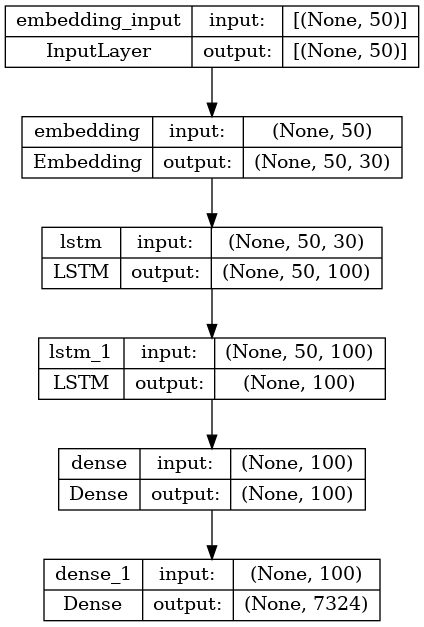

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.utils import plot_model

# define model
model = Sequential()
model.add(Embedding(vocab_size, 30, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
plot_model(model, show_shapes=True)

In [46]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
917/917 [==============================] - 58s 62ms/step - loss: 3.7323 - accuracy: 0.2493
Epoch 2/100
917/917 [==============================] - 58s 63ms/step - loss: 3.6184 - accuracy: 0.2579
Epoch 3/100
917/917 [==============================] - 57s 62ms/step - loss: 3.5835 - accuracy: 0.2621
Epoch 4/100
917/917 [==============================] - 57s 62ms/step - loss: 3.5591 - accuracy: 0.2650
Epoch 5/100
917/917 [==============================] - 58s 63ms/step - loss: 3.5370 - accuracy: 0.2674
Epoch 6/100
917/917 [==============================] - 58s 63ms/step - loss: 3.5198 - accuracy: 0.2684
Epoch 7/100
917/917 [==============================] - 58s 63ms/step - loss: 3.5003 - accuracy: 0.2723
Epoch 8/100
917/917 [==============================] - 57s 62ms/step - loss: 3.4846 - accuracy: 0.2730
Epoch 9/100
917/917 [==============================] - 57s 62ms/step - loss: 3.4685 - accuracy: 0.2755
Epoch 10/100
917/917 [==============================] - 57s 62ms/step - l

917/917 [==============================] - 57s 63ms/step - loss: 2.6649 - accuracy: 0.4015
Epoch 80/100
917/917 [==============================] - 58s 63ms/step - loss: 2.6559 - accuracy: 0.4028
Epoch 81/100
917/917 [==============================] - 58s 63ms/step - loss: 2.6476 - accuracy: 0.4045
Epoch 82/100
917/917 [==============================] - 58s 63ms/step - loss: 2.6354 - accuracy: 0.4075
Epoch 83/100
917/917 [==============================] - 58s 63ms/step - loss: 2.6320 - accuracy: 0.4074
Epoch 84/100
917/917 [==============================] - 57s 63ms/step - loss: 2.6195 - accuracy: 0.4106
Epoch 85/100
917/917 [==============================] - 57s 63ms/step - loss: 2.6139 - accuracy: 0.4114
Epoch 86/100
917/917 [==============================] - 58s 63ms/step - loss: 2.6056 - accuracy: 0.4125
Epoch 87/100
917/917 [==============================] - 57s 62ms/step - loss: 2.5958 - accuracy: 0.4145
Epoch 88/100
917/917 [==============================] - 58s 63ms/step - loss:

dict_keys(['loss', 'accuracy'])


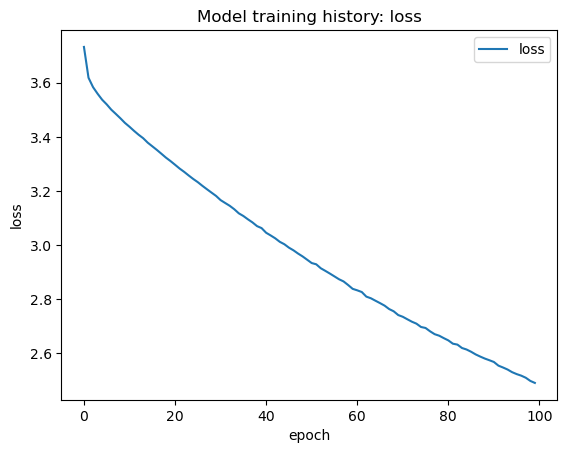

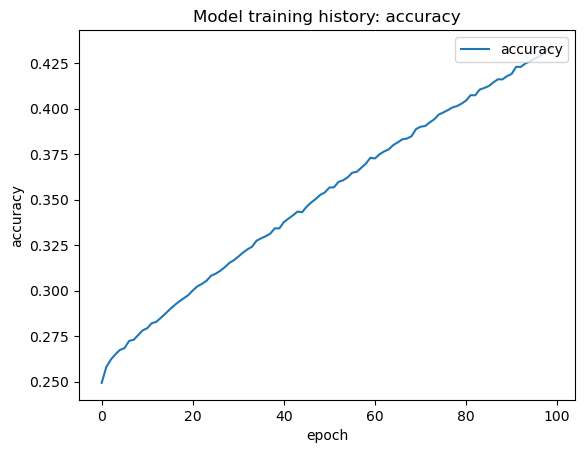

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model training history: loss')
plt.legend(['loss'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model training history: accuracy')
plt.legend(['accuracy'], loc='upper right')
plt.show()

### 모델 저장

In [48]:
from pickle import dump

# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

## 모델 사용

훈련에 사용했던 데이터 중의 일부를 사용하여 모델을 테스트합니다.

In [49]:
in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

seq_length = len(lines[0].split()) - 1
print(seq_length)

50


### 모델 적재

파일로부터 모델을 읽어서 적재합니다.

In [50]:
from pickle import load
from keras.models import load_model

model = load_model('model.h5')
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

### 텍스트 생성

In [51]:
from random import randint

# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text)

encoded = tokenizer.texts_to_sequences([seed_text])[0]
print(encoded)
encoded = encoded[:-1]
print(encoded)

fixed rate of pay enough to meet the expenses of the year and no more and they will go to mess and live together like soldiers in a camp gold and silver we will tell them that they have from god the diviner metal is within them and they have therefore
[876, 841, 3, 654, 253, 4, 745, 1, 3424, 3, 1, 2095, 2, 46, 62, 2, 17, 18, 175, 4, 5125, 2, 380, 288, 69, 859, 6, 8, 1614, 440, 2, 578, 21, 18, 180, 24, 9, 17, 23, 52, 227, 1, 5126, 2613, 5, 345, 24, 2, 17, 23, 126]
[876, 841, 3, 654, 253, 4, 745, 1, 3424, 3, 1, 2095, 2, 46, 62, 2, 17, 18, 175, 4, 5125, 2, 380, 288, 69, 859, 6, 8, 1614, 440, 2, 578, 21, 18, 180, 24, 9, 17, 23, 52, 227, 1, 5126, 2613, 5, 345, 24, 2, 17, 23]


In [52]:
# predict probabilities for each word
yhat = model.predict([encoded])
print(yhat.shape)
pred_y = yhat.argmax(axis=1)[0]
print(pred_y)

out_word = ''
for word, index in tokenizer.word_index.items():
    if index == pred_y:
        out_word = word
        break
        
print(out_word)

1/1 [==============================] - 0s 315ms/step
(1, 7324)
830
distinguished


In [53]:
from keras_preprocessing.sequence import pad_sequences

encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
print(encoded)

[[ 876  841    3  654  253    4  745    1 3424    3    1 2095    2   46
    62    2   17   18  175    4 5125    2  380  288   69  859    6    8
  1614  440    2  578   21   18  180   24    9   17   23   52  227    1
  5126 2613    5  345   24    2   17   23]]


In [54]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    
    in_text = seed_text
    
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        
        # predict probabilities for each word
        yhat = model.predict([encoded], verbose=0)
        yhat = yhat.argmax(axis=1)[0]
        
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        
        # append to input
        in_text += ' ' + out_word
        
        result.append(out_word)
        
    return ' '.join(result)

하나의 입력 데이터를 시작점으로 하여 순차적으로 50개의 단어를 생성합니다.

In [55]:
# generate new text
rand_idx = randint(0,len(lines))
seed_text = lines[rand_idx]
print('== seed_text (chosen) ==')
print(seed_text)

print('== next to seed_text ==')
print(lines[rand_idx + 50])

seed_text_words = seed_text.split()[:-1]
seed_text = ' '.join(seed_text_words)
print('== seed_text (truncated the last word) ==')
print(seed_text)

generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('== generated ==')
print(generated)

== seed_text (chosen) ==
replied very good thrasymachus i said and now to take the case of the arts you would admit that one man is a musician and another not a musician yes and which is wise and which is foolish clearly the musician is wise and he who is not a musician is
== next to seed_text ==
is foolish and he is good in as far as he is wise and bad in as far as he is foolish yes and you would say the same sort of thing of the physician yes and do you think my excellent friend that a musician when he adjusts the lyre
== seed_text (truncated the last word) ==
replied very good thrasymachus i said and now to take the case of the arts you would admit that one man is a musician and another not a musician yes and which is wise and which is foolish clearly the musician is wise and he who is not a musician
== generated ==
is foolish and are incapable of action and the other greeks revered the unjust and the other are of the state and the sufferings which are incapable of action and the ot